实战Wide & Deep模型

In [1]:
# 使用tf.keras搭建回归模型，数据集使用加利福尼亚的房价预测
#导入必要的库即版本

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
#import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd,sklearn,tf,keras:
    print(module.__name__, module.__version__)

2.0.0-beta1
sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)
matplotlib 2.2.3
numpy 1.16.4
pandas 0.23.4
sklearn 0.19.2
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
# 导入数据
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.


(20640, 8)
(20640,)


In [3]:
# 打印数据
import pprint

pprint.pprint(housing.data[:5])
pprint.pprint(housing.target[:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [4]:
# 拆分训练集、测试集、验证集
from sklearn.model_selection import train_test_split

# 默认按3：1的比例拆分
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


### 数据归一化

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# 训练机上获得均值和方差，测试集和验证集上用相同的均值和方差
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

### 构建模型

In [12]:
# 使用函数式API实现模型，即像使用函数一样调用keras model中的层次
# 输入层
input = keras.layers.Input(shape=x_train.shape[1:])
# deep模型
hidden1 = keras.layers.Dense(30, activation='relu')(input)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
# 类似复合函数：f(x) = h(g(x))


#得到deep模型的输出，需要将其与wide模型的输入一起给输出单元
#假设wide模型与deep模型输入相同
# 拼接
concat = keras.layers.concatenate([input, hidden2])
#wide模型
output = keras.layers.Dense(1)(concat)
# 用model把模型固化下来，使用Sequential返回的已经是一个固化好的模型
# 函数式API需要使用 keras.models.Model
model = keras.models.Model(inputs = [input],
                           outputs=[output])

In [16]:

model.summary()
# 编译，目标函数使用均方差，优化方法使用随机梯度下降，也可以自己定义
model.compile(loss='mean_squared_error', optimizer='sgd'(learning_rate=0.001))
# 使用earlystopping
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           270         input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 30)           930         dense_3[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 38)           0           input_2[0][0]                    
                                                                 dense_4[0][0]              

TypeError: 'str' object is not callable

In [14]:
history = model.fit(x_train_scaled, y_train,
                   validation_data = (x_valid_scaled, y_valid),
                   epochs=100, callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 35us/sample - loss: 2.2452 - val_loss: 4.0650
Epoch 2/100
11610/11610 [==============================] - 0s 26us/sample - loss: nan - val_loss: nan
Epoch 3/100
 6560/11610 [===============>..............] - ETA: 0s - loss: nan

D:\SoftWare\Anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1224: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


11610/11610 [==============================] - 0s 27us/sample - loss: nan - val_loss: nan
Epoch 4/100
11610/11610 [==============================] - 0s 27us/sample - loss: nan - val_loss: nan
Epoch 5/100
11610/11610 [==============================] - 0s 26us/sample - loss: nan - val_loss: nan
Epoch 6/100
11610/11610 [==============================] - 0s 26us/sample - loss: nan - val_loss: nan


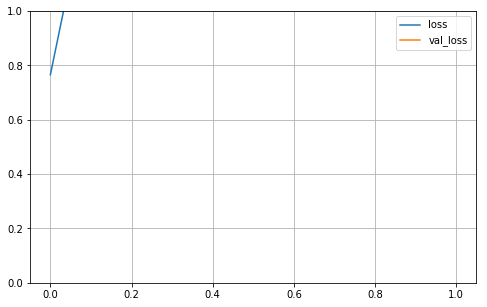

In [10]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)

In [11]:
model.evaluate(x_test_scaled, y_test)

5160/5160 [==============================] - 0s 15us/sample - loss: nan


nan